# Binary Image Classification

### A) Generating dataset

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import requests
import math
import json
import sympy
import time

# current Quokka address:
req_str_qasm = 'http://quokka1.quokkacomputing.com/qsim/qasm'

In [35]:
def generate_binary_code(bit_length):
    bit_combinations = np.zeros((int(2**bit_length), bit_length))
    for number in range(int(2**bit_length)):
        dividend = number
        bit_index = 0
        while dividend != 0:
            bit_combinations[number, bit_index] = np.remainder(dividend, 2)
            dividend = np.floor_divide(dividend, 2)
            bit_index += 1
    return bit_combinations

def generate_data(length):
    stripes = generate_binary_code(length)
    stripes = np.repeat(stripes, length, 0)
    stripes = stripes.reshape(2 ** length, length * length)

    bars = generate_binary_code(length)
    bars = bars.reshape(2 ** length * length, 1)
    bars = np.repeat(bars, length, 1)
    bars = bars.reshape(2 ** length, length * length)
    return np.vstack((stripes[1:stripes.shape[0]-1],bars[1:bars.shape[0]-1]))

THIS IS THE DATASET
[1. 0. 1. 0.]
-----------
[0. 1. 0. 1.]
-----------
[1. 1. 0. 0.]
-----------
[0. 0. 1. 1.]
-----------
THIS IS THE LABELS
[0. 0. 1. 1.]


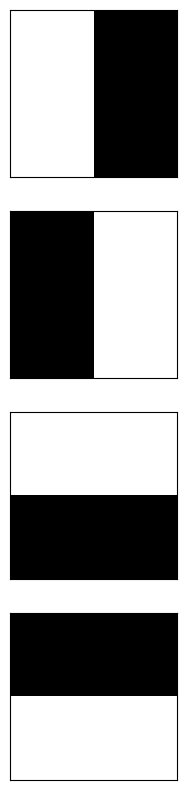

In [36]:
length = 2
dataset = generate_data(length)
labels = np.concatenate((np.zeros(int(2**length-2)),np.ones(int(2**length-2))))
n_parameters = int(2*(length**2-1))

#Plot sample data (all possiblities of straps and bars)
#Note the total number of samples fom each class is (2**length) - 2
print('THIS IS THE DATASET')
plt.figure(figsize=[10, 10])
j = 1
for i in dataset:
    print(i)
    print('-----------')
    plt.subplot(4, int(2**(length-1)-1), j)
    j += 1
    plt.imshow(np.reshape(i, [length,length]), cmap="gray")
    plt.xticks([])
    plt.yticks([])
print('THIS IS THE LABELS')
print(labels)

### B) Splitting dataset

In [37]:
# Select 75% of the entries in the array
selected_indices = np.random.choice(dataset.shape[0],
                                    int(dataset.shape[0] * 0.5),
                                    replace=False)

all_indices = np.arange(dataset.shape[0])
unselected_indices = np.setdiff1d(all_indices, selected_indices)

# Get the selected elements
training = dataset[selected_indices]
training_labels = labels[selected_indices]
test = dataset[unselected_indices]
test_labels = labels[unselected_indices]

THIS IS THE TRAINING DATASET
[0. 1. 0. 1.]
-----------
[0. 0. 1. 1.]
-----------
THIS IS THE TRAINING LABELS
[0. 1.]


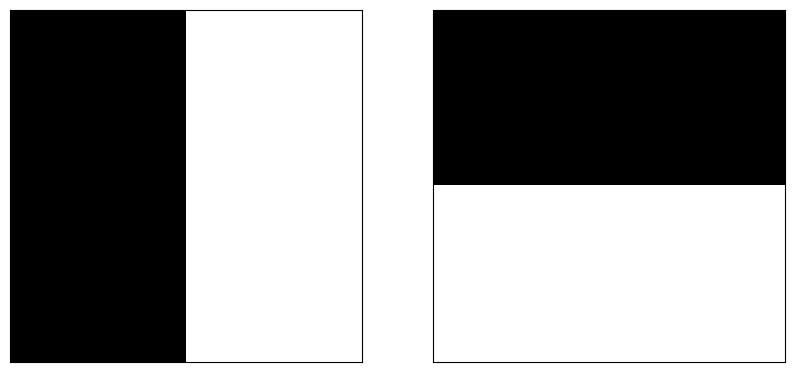

In [38]:
# Training data visualization
print('THIS IS THE TRAINING DATASET')
plt.figure(figsize=[10, 10])
j = 1
for i in training:
    print(i)
    print('-----------')
    plt.subplot(1, training.shape[0], j)
    j += 1
    plt.imshow(np.reshape(i, [length,length]), cmap="gray")
    plt.xticks([])
    plt.yticks([])
print('THIS IS THE TRAINING LABELS')
print(training_labels)

THIS IS THE TESTING DATASET
[1. 0. 1. 0.]
-----------
[1. 1. 0. 0.]
-----------
THIS IS THE TESTING LABELS
[0. 1.]


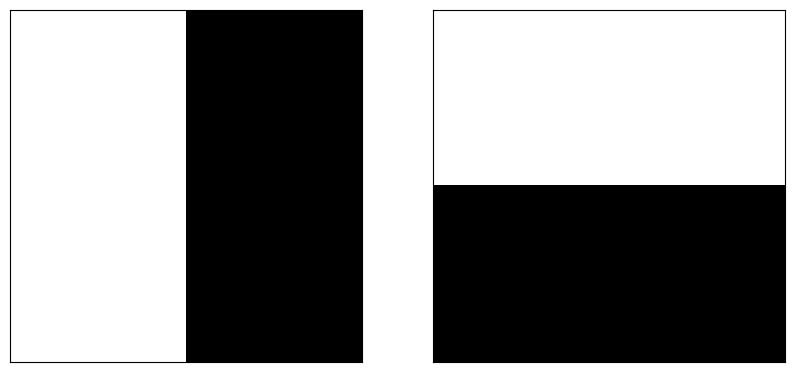

In [39]:
# Testing data visualization
print('THIS IS THE TESTING DATASET')
plt.figure(figsize=[10, 10])
j = 1
for i in test:
    print(i)
    print('-----------')
    plt.subplot(1, test.shape[0], j)
    j += 1
    plt.imshow(np.reshape(i, [length,length]), cmap="gray")
    plt.xticks([])
    plt.yticks([])
print('THIS IS THE TESTING LABELS')
print(test_labels)

### C) Creating the quantum circuit

#### The below code is to generate one block of circuit with two quantum bits as input. Use https://quantum-circuit.com/ to view this block. For an example use this qasm code:

OPENQASM 2.0;

include "qelib1.inc";

ry(2) q[0];

ry(3) q[1];

cx q[0], q[1];

#### Ultimately we need to create a block of circuits with some additional X gates to construct our final circuit for this application. For 4 input qbits, this circuit looks like for the input [1,0,1,0]:

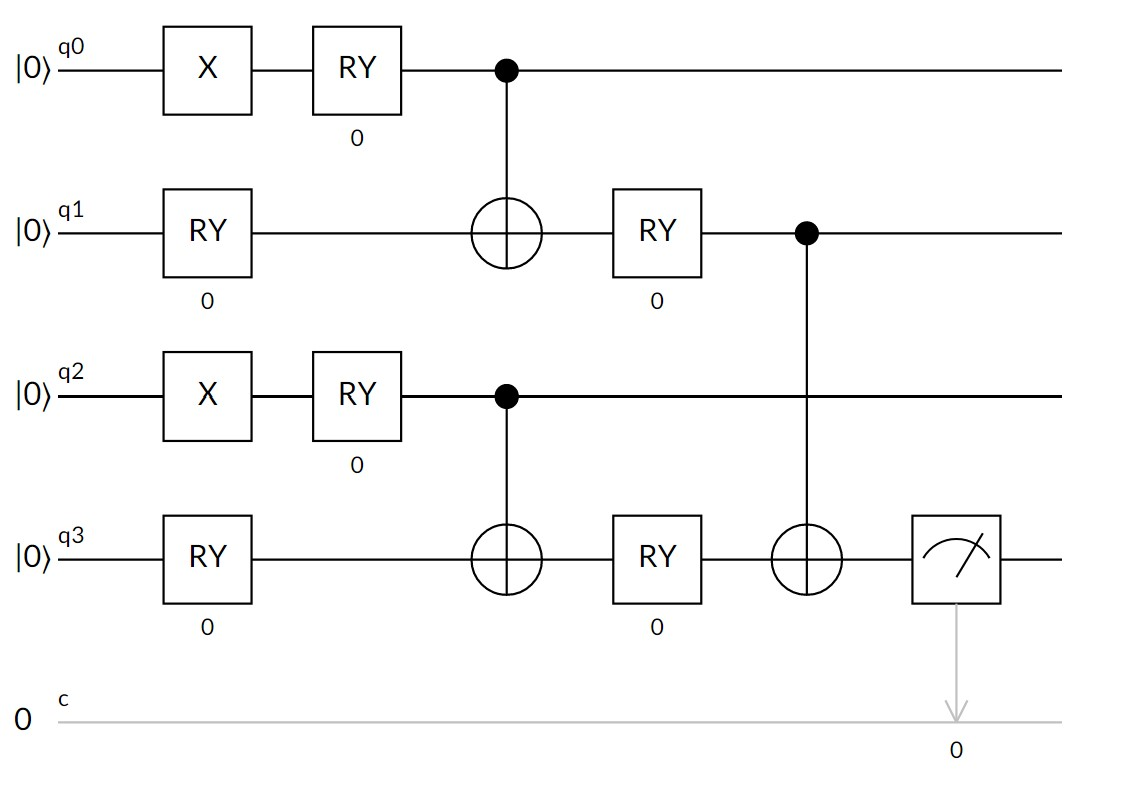


### D) The following codes will generate the required circut witht the any number of qbits as input

In [40]:
# One block circuit
def block(angles,qubits):
  qasm = '''
  ry({}) q[{}];
  ry({}) q[{}];
  cx q[{}], q[{}];
  '''.format(
      angles[0],qubits[0],
      angles[1],qubits[1],
      qubits[0],qubits[1]
  )
  return qasm

In [41]:
def generate_pairs(mylist, start, end):
  if start == end:
      pass
  else:
    mid = (start + end - 1) // 2
    first_half = generate_pairs(mylist, start, mid)
    second_half = generate_pairs(mylist, mid + 1, end)
    mylist.append((mid,end))

In [42]:
def create_circuit(data,angles):

  length = data.shape[0]

  qasm = '''
    OPENQASM 2.0;
    include "qelib1.inc";
    qreg q[{}];
    creg c[1];
    '''.format(length)

  for i in range(length):
    if data[i] > 0.5:
      qasm += '''
    x q[{}];
    '''.format(i)

  pairs = []
  generate_pairs(pairs,0,length-1)

  count = 0
  for (i,j) in pairs:
    qasm += block([angles[count],angles[count+1]],[i,j])
    count += 2

  qasm += '''
  measure q[{}] -> c[0];
  '''.format(length-1)

  return(qasm)

In [43]:
print(dataset[1])
print(np.zeros(n_parameters))

[0. 1. 0. 1.]
[0. 0. 0. 0. 0. 0.]


In [44]:
#Quickly testing the QASM
print(create_circuit(dataset[1],np.zeros(n_parameters)))


    OPENQASM 2.0;
    include "qelib1.inc";
    qreg q[4];
    creg c[1];
    
    x q[1];
    
    x q[3];
    
  ry(0.0) q[0];
  ry(0.0) q[1];
  cx q[0], q[1];
  
  ry(0.0) q[2];
  ry(0.0) q[3];
  cx q[2], q[3];
  
  ry(0.0) q[1];
  ry(0.0) q[3];
  cx q[1], q[3];
  
  measure q[3] -> c[0];
  


### E) Creating the objective function

In [45]:
def objective(x, dataset, labels, count):
    n_data = dataset.shape[0]
    to_return = 0

    for idx in range(n_data):
        qasm = create_circuit(dataset[idx],x)

        data = {'count': count,
                'script': qasm
                }

        result = requests.post(req_str_qasm, json=data)
        values = json.loads(result.content)['result']['c']

        #print(dataset[idx])
        #print(x)
        #print(values)

        to_return += np.abs(np.mean(values)-labels[idx])

    return to_return/n_data

### F) The actual training and ML/optimization algorithm

**Method 1: Using Scipy built-in function**

In [46]:
#Initialize list to store objective funciton value
obj_values = []

#To get the iteration infroamtion
def call_fn (xk):
    print("Iteration:", call_fn.iteration)
    p = objective(xk,training,training_labels,count=1)
    print("Objective Function Value:", sum(xk**2)**0.5)
    print("Parameter Values:", xk)
    print("")

    #Append objective function value to list for plotting
    obj_values.append(p)

    call_fn.iteration += 1
call_fn.iteration = 0

#The model and training process
sol = sp.optimize.minimize(lambda x: objective(x,training,training_labels,count=10),
                           x0 = np.pi*np.random.randn(n_parameters),
                           method = 'Nelder-Mead', options ={'maxiter':5},callback=call_fn)
print(sol)

Iteration: 0
Objective Function Value: 7.019733321426041
Parameter Values: [ 0.16925784  2.31603341  3.63672415  0.17658112  5.46366233 -0.88059499]

Iteration: 1
Objective Function Value: 7.126467953924281
Parameter Values: [ 0.16522789  2.31603341  3.63672415  0.17658112  5.60025388 -0.88059499]

Iteration: 2
Objective Function Value: 7.126467953924281
Parameter Values: [ 0.16522789  2.31603341  3.63672415  0.17658112  5.60025388 -0.88059499]

Iteration: 3
Objective Function Value: 7.126467953924281
Parameter Values: [ 0.16522789  2.31603341  3.63672415  0.17658112  5.60025388 -0.88059499]

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 0.25
             x: [ 1.652e-01  2.316e+00  3.637e+00  1.766e-01  5.600e+00
                 -8.806e-01]
           nit: 5
          nfev: 19
 final_simplex: (array([[ 1.652e-01,  2.316e+00, ...,  5.600e+00,
                        -8.806e-01],
                       [ 1.693e-01

##Modify the training process

In [47]:
#The model and training process
start_time = time.time()
sol = sp.optimize.minimize(lambda x: objective (x, training, training_labels,count=10),
                           x0 = np.pi*np.random.randn(n_parameters),
                           method = 'Nelder-Mead', options = {'maxiter':5}, callback=call_fn)
end_time = time.time()

print("Total Time Taken:", end_time - start_time)

Iteration: 4
Objective Function Value: 3.4928299900584268
Parameter Values: [-1.80585559 -1.21653266 -1.92305937 -1.84810859  0.4482881   0.37969757]

Iteration: 5
Objective Function Value: 3.4928299900584268
Parameter Values: [-1.80585559 -1.21653266 -1.92305937 -1.84810859  0.4482881   0.37969757]

Iteration: 6
Objective Function Value: 3.4928299900584268
Parameter Values: [-1.80585559 -1.21653266 -1.92305937 -1.84810859  0.4482881   0.37969757]

Iteration: 7
Objective Function Value: 3.4928299900584268
Parameter Values: [-1.80585559 -1.21653266 -1.92305937 -1.84810859  0.4482881   0.37969757]

Total Time Taken: 15.928467988967896


## Plotting the Iteration Number against the Output Measure

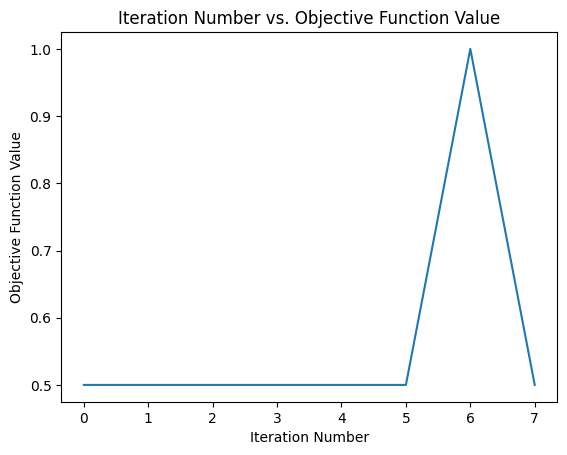

In [48]:
plt.figure()
plt.plot(range(len(obj_values)), obj_values)
plt.xlabel('Iteration Number')
plt.ylabel('Objective Function Value')
plt.title('Iteration Number vs. Objective Function Value')
plt.show()

##Plotting the Iteration Number against the Time Required

Total Time Taken: 13.706870079040527


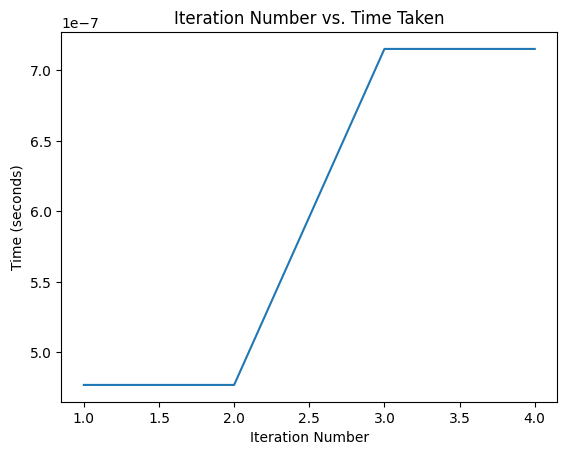

In [49]:
# Initialize list to store time taken at each iteration
times = []

def call_fn(xk):
    start = time.time()
    # Your existing code here
    end = time.time()
    times.append(end - start)

# Modify the training process to use the new callback function

# The model and training process
start_time = time.time()
sol = sp.optimize.minimize(lambda x: objective(x,training,training_labels,count=10),
                           x0 = np.pi*np.random.randn(n_parameters),
                           method = 'Nelder-Mead', options ={'maxiter':5},callback=call_fn)
end_time = time.time()

print("Total Time Taken:", end_time - start_time)

plt.figure()
plt.plot(range(1, len(times) + 1), times)
plt.xlabel('Iteration Number')
plt.ylabel('Time (seconds)')
plt.title('Iteration Number vs. Time Taken')
plt.show()


**Method 2: Using spsa optimizer**

For more information: https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fen.wikipedia.org%2Fwiki%2FSimultaneous_perturbation_stochastic_approximation

The Simultaneous Perturbation Stochastic Approximation (SPSA) algorithm is a popular stochastic optimization technique for solving optimization problems in a variety of applications. It was first introduced by Spall in 1992 as a variant of the stochastic approximation method.

SPSA is a gradient-free optimization algorithm, meaning that it does not require knowledge of the gradient of the objective function. Instead, it uses a series of random perturbations to estimate the gradient of the objective function at each iteration. This makes it well-suited for optimizing functions that are expensive or difficult to compute gradients for.

At each iteration, the SPSA algorithm randomly perturbs the input variables and computes the corresponding function values. It then uses these function values to estimate the gradient of the objective function, and updates the input variables using a stochastic approximation rule. This process is repeated until convergence is achieved or a stopping criterion is met.

One of the key advantages of SPSA is its simplicity and ease of implementation.

In [50]:
#The actual code for the optimizer
def spsa(func, x0, a=0.1, c=0.01, alpha=0.602, gamma=0.101, maxiter=100, verbose=False):

    k = 0
    x = x0

    while k < maxiter:
        ak = a / (k+1)**alpha
        ck = c / (k+1)**gamma
        delta = 2 * np.random.randint(0, 2, len(x0)) - 1
        xp = x + ck * delta
        xm = x - ck * delta
        grad = (func(xp) - func(xm)) / (2 * ck) * delta

        x = x - ak * grad

        # Print progress message
        if verbose and k % int(0.1*maxiter) == 0:
            fx = func(x)
            print(f"Iteration {k}: f = {fx}")

        k += 1

    return x

# Some parameters to set
a = 1
c = 0.5
maxiter= 10
alpha = 0.602
gamma = 0.101

f = lambda x: objective(x,training,training_labels,count=10)
x0 = np.pi*np.random.randn(n_parameters)

sol = spsa(f, x0, a=a, c=c,
            alpha=alpha, gamma=gamma,
            maxiter=maxiter, verbose=True)

Iteration 0: f = 0.6
Iteration 1: f = 0.6
Iteration 2: f = 0.4
Iteration 3: f = 0.55
Iteration 4: f = 0.4
Iteration 5: f = 0.45
Iteration 6: f = 0.4
Iteration 7: f = 0.55
Iteration 8: f = 0.55
Iteration 9: f = 0.30000000000000004


### G) Testing of data

In [51]:
# Actual testing function
def testing_circuit(x, dataset):
    count = 1
    n_data = dataset.shape[0]
    output_labels = []
    for idx in range(n_data):
        qasm = create_circuit(dataset[idx],x)
        data = {'count': count, 'script': qasm}
        result = requests.post(req_str_qasm, json=data)
        values = json.loads(result.content)['result']['c'][0]
        output_labels.append(values)
    return output_labels

In [52]:
# Calling the testing fuction to get the predicted classes
output_labels = testing_circuit(np.array(sol), test)
output_labels = np.array(output_labels).flatten()

In [53]:
output_labels

array([1, 1])

In [54]:
test_labels

array([0., 1.])

#Modified code for simulating the quantum circuit on a classical machine

Iteration: 0
Objective Function Value: 4.569301730099958
Parameter Values: [ 0.64207555 -0.60890116 -3.48304616 -2.27881022  1.27799993  1.06659563]

Iteration: 1
Objective Function Value: 4.569301730099958
Parameter Values: [ 0.64207555 -0.60890116 -3.48304616 -2.27881022  1.27799993  1.06659563]

Iteration: 2
Objective Function Value: 4.569301730099958
Parameter Values: [ 0.64207555 -0.60890116 -3.48304616 -2.27881022  1.27799993  1.06659563]

Iteration: 3
Objective Function Value: 4.651340089566921
Parameter Values: [ 0.64773759 -0.58183888 -3.6894489  -2.12899955  1.27918326  1.04684386]

Total Time Taken: 0.014735221862792969


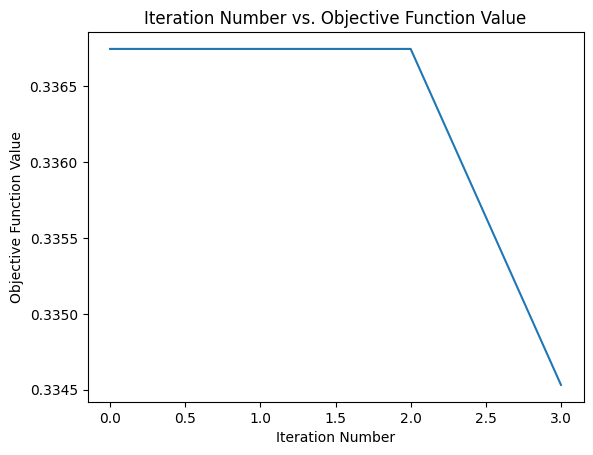

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import requests
import json
import time

# Define functions for generating data and simulating quantum circuit
def generate_binary_code(bit_length):
    bit_combinations = np.zeros((int(2**bit_length), bit_length))
    for number in range(int(2**bit_length)):
        dividend = number
        bit_index = 0
        while dividend != 0:
            bit_combinations[number, bit_index] = np.remainder(dividend, 2)
            dividend = np.floor_divide(dividend, 2)
            bit_index += 1
    return bit_combinations

def generate_data(length):
    stripes = generate_binary_code(length)
    stripes = np.repeat(stripes, length, 0)
    stripes = stripes.reshape(2 ** length, length * length)

    bars = generate_binary_code(length)
    bars = bars.reshape(2 ** length * length, 1)
    bars = np.repeat(bars, length, 1)
    bars = bars.reshape(2 ** length, length * length)
    return np.vstack((stripes[1:stripes.shape[0]-1], bars[1:bars.shape[0]-1]))

def simulate_circuit(data, angles):
    length = len(data)
    qubits = np.zeros(length)

    for i in range(length):
        if data[i] > 0.5:
            qubits[i] = 1

    pairs = []
    generate_pairs(pairs, 0, length - 1)

    for (i, j) in pairs:
        qubits[j] = np.cos(angles[0]) * qubits[j] + np.sin(angles[0]) * qubits[i]
        qubits[i] = np.cos(angles[1]) * qubits[i] + np.sin(angles[1]) * qubits[j]

    return np.mean(qubits)

# Define objective function and training process
def objective(x, dataset, labels, count):
    n_data = dataset.shape[0]
    to_return = 0

    for idx in range(n_data):
        simulated_value = simulate_circuit(dataset[idx], x)
        to_return += np.abs(simulated_value - labels[idx])

    return to_return / n_data

def call_fn(xk):
    global obj_values
    print("Iteration:", call_fn.iteration)
    p = objective(xk, training, training_labels, count=1)
    print("Objective Function Value:", sum(xk**2)**0.5)
    print("Parameter Values:", xk)
    print("")

    obj_values.append(p)
    call_fn.iteration += 1
call_fn.iteration = 0

# Generate dataset
length = 2
dataset = generate_data(length)
labels = np.concatenate((np.zeros(int(2**length-2)),np.ones(int(2**length-2))))
n_parameters = int(2*(length**2-1))

# Split dataset
selected_indices = np.random.choice(dataset.shape[0],
                                    int(dataset.shape[0] * 0.5),
                                    replace=False)
all_indices = np.arange(dataset.shape[0])
unselected_indices = np.setdiff1d(all_indices, selected_indices)
training = dataset[selected_indices]
training_labels = labels[selected_indices]
test = dataset[unselected_indices]
test_labels = labels[unselected_indices]

# Training process
obj_values = []
start_time = time.time()
sol = sp.optimize.minimize(lambda x: objective(x, training, training_labels, count=10),
                           x0=np.pi*np.random.randn(n_parameters),
                           method='Nelder-Mead', options={'maxiter': 5}, callback=call_fn)
end_time = time.time()

print("Total Time Taken:", end_time - start_time)

# Plotting
plt.figure()
plt.plot(range(len(obj_values)), obj_values)
plt.xlabel('Iteration Number')
plt.ylabel('Objective Function Value')
plt.title('Iteration Number vs. Objective Function Value')
plt.show()
